# Live imaging notebook: Lineage trees and 3D tracks on raw data using Napari
Sendra et al. 2025 Dev Cell

## Import python libraries
Leo Guignard´s lineageTree library to read and analyse Mamut (and other) lineage tree files.
https://github.com/GuignardLab/LineageTree


In [1]:
# For lineage tree plotting
from LineageTree import lineageTree 
import svgwrite
from IPython.display import SVG, display  # Added for displaying SVG

import sys
import os

# For 3D visualization
import numpy as np
from skimage.io import imread
import napari
from skimage.transform import rescale
import tifffile as tiff
from concurrent.futures import ThreadPoolExecutor

c:\Users\msendra\AppData\Local\Continuum\anaconda2\envs\napari-env\lib\site-packages\LineageTree\lineageTree.py:22: UserWarning: No edist installed therefore you will not be able to compute the tree edit distance.
  warnings.warn(
c:\Users\msendra\AppData\Local\Continuum\anaconda2\envs\napari-env\lib\site-packages\LineageTree\utils.py:11: UserWarning: No motile installed therefore you will not be able to produce links with motile.
  warnings.warn(
c:\Users\msendra\AppData\Local\Continuum\anaconda2\envs\napari-env\lib\site-packages\LineageTree\lineageTreeManager.py:9: UserWarning: No edist installed therefore you will not be able to compute the tree edit distance.
  warnings.warn(


## Define relative paths to data, results, figures and custom modules (functions for analysis and plotting made for this Repository)


In [2]:
# paths to data
mamut_file = r'../data/MS4_tracking_MaMut.xml'

# output dirs
out = r'../figures'
results = r'../results'

# modules (other functions) path
scripts = r'../scripts'

# Add the scripts folder to the Python path
sys.path.append(scripts)

#from clonalpy import contribution_heatmap

output_file = os.path.join(out, os.path.basename(mamut_file).replace(".xml", ".svg"))

# Initialize lineage tree
lineage_tree = lineageTree(mamut_file, file_type='MaMuT')

## Define standard colors for cell fate

In [3]:
# Define colors
ET_COLOR = (0, 191, 196)  # Blue
CM_COLOR = (249, 118, 110)  # Red
MES_COLOR = (165, 104, 42)  # Brown

def get_color_by_name(cell_name, color_mapping):
    """Returns the color based on the cell name and mapping."""
    cell_name = cell_name.lower()
    for substrings, color in color_mapping.items():
        if any(substring in cell_name for substring in substrings):
            return color
    return MES_COLOR

# Define color mappings
COLOR_MAPPING = {
    ('ec', 'et', 'uc'): ET_COLOR,
    ('cm', 'my'): CM_COLOR,
    ('mes', 'jcf'): MES_COLOR
}

def stroke_color(cell):
    """Returns the stroke color for a cell."""
    return get_color_by_name(lineage_tree.track_name[cell], COLOR_MAPPING)

def node_color(cell):
    """Returns the node color for a cell."""
    # Use .get() to avoid KeyError and provide a default color
    track_name = lineage_tree.track_name.get(cell, None)
    if track_name is None:
        # Skip this cell if the track name is not found
        #print(f"Warning: Track name not found for cell {cell}. Skipping.")
        return (128, 128, 128)  # Default gray color for missing cells
    return get_color_by_name(track_name, COLOR_MAPPING)

def node_size(cell):
    """Returns the size of a node based on its division status."""
    if not lineage_tree.successor.get(cell):  # No successor
        return 0.24
    if not lineage_tree.predecessor.get(cell):  # No predecessor
        return 0.5
    return 0

## Plot Lineage Tree (Figures 3 and S4)
Note that some lineage tree braches are plot wrong, manual correction in Adobe Illustrator is required

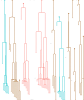

In [4]:
# Write lineage tree to SVG
lineage_tree.write_to_svg(
    output_file,
    node_size=node_size,
    node_color=node_color,
    stroke_color=stroke_color
)

# Display the SVG in the notebook
display(SVG(output_file))

## Create 3D spots and tracks representations in Napari (Figure S3 and Videos)

In [ ]:
# Input files and parameters
mamut_file = r'../data/MS1_tracking_MaMut.xml'
image_folder_c0 = r'../data/registered-rigid-c0'
image_folder_c1 = r'../data/registered-rigid-c1'

timescale = 20
voxel_size = np.array([5, 1.18, 1.18])  # voxel el size in um for z,y,x
downscale_factor = 2

# Load lineage tree
lT = lineageTree(mamut_file, file_type='MaMuT')

In [ ]:
# Factor to make the XYZ coordinates match the image size when downscaled
downscale_restore_scale = np.array([1, downscale_factor, downscale_factor]) # affecting y and x axes

# In case the image is not isotropic and this info is not contained in the metadata
proportion_restore_scale = np.array([1, 1, 1]) # set to 1 to leave unaltered

# Apply same scale to the points so that they match
proportion_restore_scale_points = np.array([1, 1, 1, 1]) # set to 1 to leave unaltered


# Aesthetic parameters
point_size = 8
tail_length = 5
tail_width = 3
opacity = 0.7

In [ ]:
def load_and_downscale_image(file, downscale_factor):
    image = tiff.imread(file)
    # Downscale X and Y by slicing
    return image[:, ::downscale_factor, ::downscale_factor]  # Keep Z, downscale Y and X
# this downscaling does not use interpolation, just takes once every 5 pixels in X and Y

def load_and_rescale_images_fast(folder, downscale_factor):
    """
    Load and rescale all images in a folder regardless of their names.

    Parameters:
        folder (Path or str): The path to the folder containing the images.
        downscale_factor (float): Factor to downscale the images.

    Returns:
        np.ndarray: A stacked array of all processed images.
    """
    # Convert folder to Path object if it's a string
    folder = Path(folder)

    # Get all files in the folder
    files = sorted(folder.glob("*.tif"))

    # Load and process images in parallel
    with ThreadPoolExecutor() as executor:
        images = list(executor.map(lambda file: load_and_downscale_image(file, downscale_factor), files))

    return np.stack(images, axis=0)  # Stack along time axis


# load dowsncaled image if it is already available
output_path = Path(image_folder_c0).parent / f"downsampled_{downscale_factor}_multichannel_image.tif"

# Check if the processed image already exists
if output_path.exists():  # If already loaded and downsampled, no need to process again

    print(f"Downsample image was found is being loaded from {output_path}")

    multi_channel_image = imread(output_path)

    print(f"Downsample image was loaded succesfully")



else:  # Load and downsample the image, then save it
    print(f"No dowsampled image was found, the original image in {image_folder_c0} is being loaded, downsampled by {downscale_factor}")
    image_c0 = load_and_rescale_images_fast(image_folder_c0, downscale_factor)
    image_c1 = load_and_rescale_images_fast(image_folder_c1, downscale_factor)

    multi_channel_image = np.stack([image_c0, image_c1], axis = 0)

    tiff.imsave(output_path, multi_channel_image)  # Save as uint16 to preserve intensity
    print(f"The downsampled time-lapse image has been saved to {output_path}")



In [35]:
# Output path for downscaled image
output_path = os.path.join(os.path.dirname(image_folder_c0), f"downsampled_{downscale_factor}_multichannel_image.tif")

if os.path.exists(output_path):  # Use os.path.exists() to check if the file exists
    print(f"Loading downsampled image from {output_path}")
    multi_channel_image = imread(output_path)
    print(f"Image was loaded succesfully")

else:
    print(f"Processing and downsampling images from {image_folder_c0} and {image_folder_c1}")
    image_c0 = process_images_in_folder(image_folder_c0, downscale_factor)
    image_c1 = process_images_in_folder(image_folder_c1, downscale_factor)
    multi_channel_image = np.stack([image_c0, image_c1], axis=0)
    tiff.imsave(output_path, multi_channel_image)
    print(f"Saved downsampled image to {output_path}")

Loading downsampled image from ../data\downsampled_2_multichannel_image.tif
Image was loaded succesfully


## Plot tracks in Napari

Refer to:
- https://napari.org/stable/howtos/layers/tracks.html
- https://napari.org/stable/gallery/tracks_3d_with_graph.html

In [36]:
multi_channel_image.shape  # Check the shape of the downsampled image generated in the previous step

(2, 83, 206, 453, 497)

In [37]:
# Rearrange axes by swaping channel and time order according to napari's requirements
# Napari expects the shape to be (time, channels, z, y, x) right now it is (channels, time, z, y, x)
multi_channel_image = np.transpose(multi_channel_image, (1, 0, 2, 3, 4))

In [38]:
multi_channel_image.shape  # Check the shape of the downsampled image generated in the previous step

(83, 2, 206, 453, 497)

In [39]:
def reorder_positions(positions):
    """Reorder positions to match image coordinates."""
    return positions[[2, 1, 0]] if positions.size > 0 else positions

In [40]:
# Define fate equivalence mapping
fate_equivalence = {
    ("CM", "EC"): "CM+EC",
    "CM": "CM",
    "EC": "EC",
    "JCF": "JCF",
    "Head": "Head",
    "SHF": "SHF",
    "EmEt": "EmEt",
    "ExM": "ExM",
    "ExEt": "ExEt",
}

# Collect fates for nodes with "Initial" in their name
track_fates = {
    lineage_tree.track_name[node_id]: next(
        (fate for keys, fate in fate_equivalence.items()
         if all(f" {key} " in f" {lineage_tree.node_name[node_id]} " for key in (keys if isinstance(keys, tuple) else [keys]))),
        None
    )
    for node_id in lineage_tree.nodes if "Initial" in lineage_tree.node_name[node_id]
}

# Propagate fates to all nodes
node_fates = {
    node_id: track_fates.get(lineage_tree.track_name.get(node_id, None), "undetermined")
    for node_id in lineage_tree.nodes
}

# Define color mappings
fate_to_node_color = {
    'EC': 'limegreen', 'CM': 'lightcoral', 'JCF': 'burlywood',
    'Head': 'burlywood', 'SHF': 'burlywood', 'EmEt': 'forestgreen',
    'ExM': 'gray', 'ExEt': 'forestgreen', 'CM+EC': 'yellow',
    'undetermined': 'gray'
}

fate_to_edge_color = {
    'EC': 'limegreen', 'CM': 'lightcoral', 'JCF': 'lightblue',
    'Head': 'pink', 'SHF': 'brown', 'EmEt': 'forestgreen',
    'ExM': 'thistle', 'ExEt': 'thistle', 'CM+EC': 'yellow',
    'undetermined': 'gray'
}

# Assign colors to nodes and edges
node_colors = [fate_to_node_color.get(fate, 'gray') for fate in node_fates.values()]
edge_colors = [fate_to_edge_color.get(fate, 'gray') for fate in node_fates.values()]

# Prepare track data
tracks = np.array([[node_id, lineage_tree.time[node_id]] + reorder_positions(lineage_tree.pos[node_id]).tolist() for node_id in lineage_tree.nodes])

# Build graph
graph = {node_id: lineage_tree.predecessor.get(node_id) for node_id in lineage_tree.nodes if lineage_tree.predecessor.get(node_id) is not None}

# Filter tracks and colors for determined fates
mask = np.array([fate != 'undetermined' for fate in node_fates.values()])
tracks = tracks[mask]
node_colors = np.array(node_colors)[mask]
edge_colors = np.array(edge_colors)[mask]
graph = {node_id: parent for node_id, parent in graph.items() if node_id in node_fates and node_fates[node_id] != 'undetermined'}

# Prepare features for visualization
features = {
    'time': tracks[:, 1],
    'fate': np.array(list(node_fates.values()))[mask]
}

# Visualize in Napari
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(
    multi_channel_image,
    name="Multi-Channel Time-Lapse",
    scale=voxel_size * downscale_restore_scale * proportion_restore_scale,
    colormap=["green", "gray"],
    channel_axis=1
)
viewer.add_points(
    tracks[:, 1:], size=point_size, name='points', opacity=opacity,
    face_color=node_colors, edge_color=edge_colors, scale=proportion_restore_scale_points
)
viewer.add_tracks(
    tracks, graph=graph, features=features, name='tracks',
    tail_length=tail_length, tail_width=tail_width, head_length=0, scale=proportion_restore_scale
)

# Add scale bar
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'
viewer.scale_bar.font_size = 30
viewer.scale_bar.position = 'bottom_left'

# Add time overlay
def format_time(value):
    total_minutes = int(value * time_scale)
    hours, minutes = divmod(total_minutes, 60)
    return f"{hours:02d}:{minutes:02d}"

time_values = np.arange(multi_channel_image.shape[0])

def update_time(viewer, event):
    current_frame = int(viewer.dims.current_step[0])
    if current_frame < len(time_values):
        viewer.text_overlay.text = f"Time: {format_time(time_values[current_frame])}"
    else:
        viewer.text_overlay.text = "Out of range"

viewer.text_overlay.visible = True
viewer.text_overlay.text = "Time: N/A"
viewer.text_overlay.color = "white"
viewer.text_overlay.font_size = 30
viewer.dims.events.current_step.connect(lambda event: update_time(viewer, event))

C:\Users\msendra\AppData\Roaming\Python\Python39\site-packages\napari\utils\migrations.py:101: FutureWarning: Argument 'edge_color' is deprecated, please use 'border_color' instead. The argument 'edge_color' was deprecated in 0.5.0 and it will be removed in 0.6.0.
  return func(*args, **kwargs)


<function __main__.<lambda>(event)>

## Save layers

In [ ]:
import json

def save_layers(viewer, save_folder):
    """Save Napari layers and metadata."""
    os.makedirs(save_folder, exist_ok=True)
    metadata = {}

    for layer in viewer.layers:
        layer_name = layer.name
        layer_path = Path(save_folder) / f"{layer_name}.npy"
        if hasattr(layer, "data"):
            np.save(layer_path, layer.data)
        metadata[layer_name] = {
            "type": layer.__class__.__name__,
            "scale": layer.scale.tolist(),
            "metadata": layer.metadata,
            "face_color": getattr(layer, "face_color", None),
            "edge_color": getattr(layer, "edge_color", None)
        }
    metadata_path = Path(save_folder) / "metadata.json"
    with open(metadata_path, "w") as f:
        json.dump(metadata, f, indent=4)